In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Данные константы
k = 0.011  # (Вт/см/K)
c = 1.6  # (Дж/см3/K)
alpha = 0.005  # (Вт/см2/K)
l = 0.5  # длина цилиндра (см)
radius = 4  # радиус (см)
beta = 0.008  # (1/см)
t = 180  # время наблюдения (c)
u0 = 0  # температура окружающей среды (K)

In [3]:
# Задаем число отсчетов и шаги
num_m = 1000
num_i = 100
tau = t/num_m # шаг по времени
r_arr = np.linspace(0,radius,num_i) # массив точек распредленных [0,R]
t_arr = np.linspace(0,t, num_m)
h = radius/num_i # шаг по координате r
w = np.zeros((num_i, num_m))

In [4]:
import scipy.optimize
def bessel(x):
    return scipy.special.jv(1,x)
res = scipy.optimize.root(bessel, 3.8) # нахождение нуля функции в окрестности точки x = 3.8
mu1 = float(res.get('x'))  # первый нуль функции бесселя первого порядка

In [5]:
def intensive(i): # интенсивность в i-ой точке
    assert i<num_i, "функция intensive(r) определена только для r<radius"
    return scipy.special.jv(0, mu1*i*h/radius)

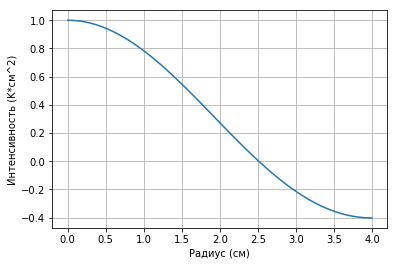

In [6]:
plt.plot(r_arr,scipy.special.jv(0, mu1*r_arr/radius)) #нарисуем интенсивность
plt.ylabel('Интенсивность (K*см^2)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

In [7]:
a_const = c/tau+4*k/h**2+2*alpha/l
b_const = -4*k/h**2
def c_const(i):
    return -k/h**2 + k/(2*h*i*h)
d_const = c/tau + 2*k/h**2 + 2*alpha/l
def e_const(i):
    return -k/h**2 - k/(2*h*i*h)
f_const = -2*k/h**2
g_const = c/tau + 2*k/h**2 + 2*alpha/l
h_const = c/tau
def q_const(i):
    return beta/l*intensive(i)

In [8]:
P = np.zeros((num_i, num_i))
P[0,0] = a_const
P[0,1] = b_const
for i in range(1,num_i-1):  # по всем индексам кроме нулевого и последнего
    P[i,i-1] = c_const(i)
    P[i,i] = d_const
    P[i,i+1] = e_const(i)
P[-1,-2] = f_const
P[-1,-1] = g_const

In [9]:
P

array([[ 36.40888889, -27.5       ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ -3.4375    ,  22.65888889, -10.3125    , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -5.15625   ,  22.65888889, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  22.65888889,
         -6.91043814,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,  -6.83992347,
         22.65888889,  -6.91007653],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -13.75      ,  22.65888889]])

In [10]:
# краевое условие
w[:,0] = 0 # при t = 0

In [11]:
q = np.zeros((1,num_i))
for i in range(num_i):
    q[0,i] = beta/l*intensive(i)
q.T.shape

(100, 1)

In [12]:
# В этой ячейке достаем из матрицы P три диагонали
n = len(w[:,0])
P_c = []
for i in range(n):
    P_c.append(P[i,i])
P_b = [] # над
for i in range(n-1):
    P_b.append(P[i,i+1])
P_a= [] # под
for i in range(1,n):
    P_a.append(P[i,i-1])

In [13]:
"""
b - диагональ, лежащая над главной (нумеруется: [0;n-2])
c - главная диагональ матрицы A (нумеруется: [0;n-1])
a - диагональ, лежащая под главной (нумеруется: [1;n-1])
f - правая часть (столбец)
return: решение, массив x будет содержать ответ
"""
def TDMA(a,b,c,f): # Tridiagonal matrix algorithm
    #a, b, c, f = map(lambda k_list: map(float, k_list), (a, b, c, f))
    alpha = [0]
    beta = [0]
    n = len(f) #  n - число уравнений (строк матрицы)
    x = [0]*n
    

    for i in range(n-1):
        alpha.append(-b[i]/(a[i]*alapha[i] + c[i]))
        beta.append((f[i] - a[i]*beta[i])/(a[i]*alpha[i] + c[i]))

    x[n-1] = (f[n-1] - a[n-2]*beta[n-1])/(c[n-1] + a[n-2]*alpha[n-1])

    for i in reversed(range(n-1)):
        x[i] = alpha[i+1]*x[i+1] + beta[i+1]

    return x

In [14]:
# for m in range(0,num_m-1): # идем послойно, по времени
#     right_column = (h_const*w[:,m]+q)
#     w[:,m+1] = np.array(TDMA(P_a, P_b, P_c, right_column))

In [15]:
for m in range(0,num_m-1): # идем послойно, по времени
    right_column = (h_const*w[:,m]+q).T
    w[:,m+1] = np.linalg.solve(P,right_column)[:,0]

In [16]:
v = w + u0

In [17]:
min_max_v = (np.min(v), np.max(v)) # необходимо, чтобы все рисунки были отрисованы в одном масштабе
min_max_v

(-0.2010645215794112, 0.5135525686534398)

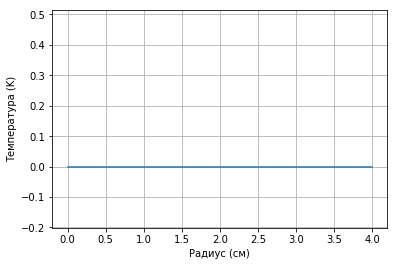

In [18]:
plt.plot(r_arr,v[:,0]) # распредление по радиусу в начальный момент времени
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

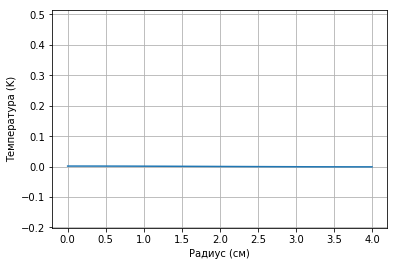

In [19]:
plt.plot(r_arr,v[:,1]) # распредление по радиусу во время второго отсчета по времени
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

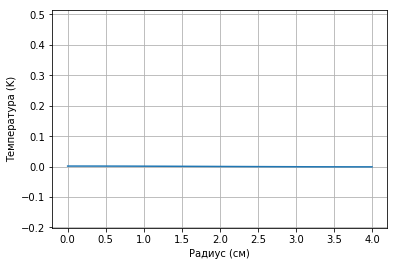

In [20]:
plt.plot(r_arr,v[:,1]) # распредление по радиусу во время 1 отсчета по времени (уже стационарное состояние)
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Радиус (см)')
plt.grid(True) 
plt.show()

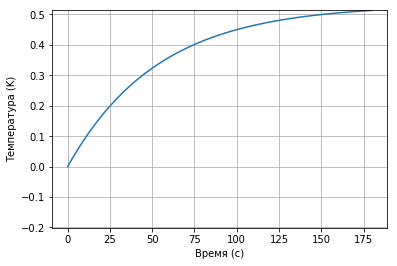

In [21]:
plt.plot(t_arr,v[0,:]) # распредление по времени во точке r = 0
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True) 
plt.show()

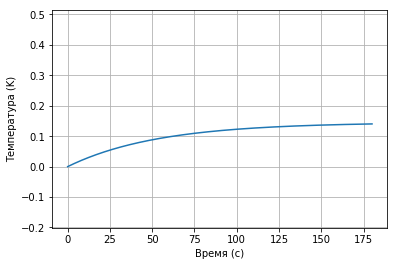

In [22]:
plt.plot(t_arr,v[num_i//2,:]) # распредление по времени во точке r = R/2
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True) 
plt.show()

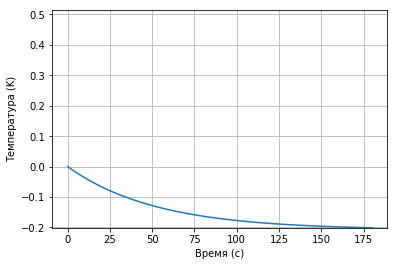

In [23]:
plt.plot(t_arr,v[-1,:]) # распредление по времени во точке r = R
try:
    plt.ylim(min_max_v)
except:
    pass
plt.ylabel('Температура (K)')
plt.xlabel('Время (с)')
plt.grid(True) 
plt.show()

In [24]:
w[-1,10] # Температура на при r = R, во время 10 отсчета

-0.0070887684209517965

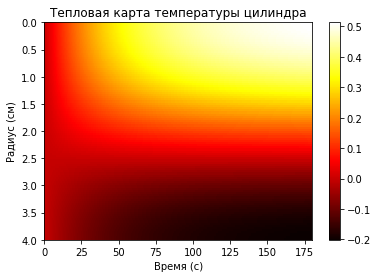

In [25]:
import matplotlib.cm as cmap
extent = [np.min(t_arr), np.max(t_arr), np.max(r_arr), np.min(r_arr)]
plt.imshow(v, cmap=cmap.hot, aspect='auto', extent=extent)
plt.title("Тепловая карта температуры цилиндра")
plt.ylabel('Радиус (см)')
plt.xlabel('Время (с)')
plt.colorbar()
plt.show()